# **<노드 실습>**



---


## 프로젝트 요약
- 기존 코드 (랜덤포레스트 모델) -> 정확도: 0.6910994764397905
- 1) XGBoost + GridSearchCV -> 정확도: 0.6178010471204188
- 2) XGBoost + GridSearchCV + 다양한 PKFold split, 데이터 비율, 데이터 수로 반복 실험
  - PKFold split: 3 -> 정확도: 0.5287958115183246
  - PKFold split: 5 -> 정확도: 0.4973821989528796
- 3) 학습 데이터 10000개로 늘리기 -> 정확도: 0.6178010471204188
- 4) 라벨링 방법 변화 -> 정확도: 0.6061

---



## **노드 10 - Finance Time Series 데이터 활용하기**

## 프로젝트 목표
- 1) 데이터 라벨링
- 2) 피처 엔지니어링
- 3) 모델 학습

## 1) Data Labeling

### 1) 추세 판단 분류기 만들기

- 지도학습 기반 분류기를 개발해본다.
- 상승: 1, 하락:0 -> labeling 수행한다.
- 분류기는 랜덤포레스트 모델을 기반으로, bagging 분류기를 만든다.

#### 1) 데이터 불러오기
- 일단, 데이터를 불러온다.

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

<Axes: xlabel='time'>

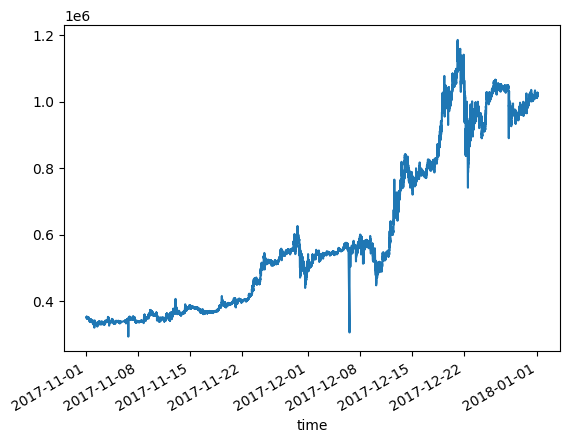

In [ ]:
# 이 데이터는 17년 11월 12월 2달간의 변화 close는 종가
DATA_PATH = '.'
modify_data = pd.read_csv(os.path.join(DATA_PATH, '/content/sub_upbit_eth_min_tick.csv'), index_col=0, parse_dates=True)
modify_data.loc['2017-11-01':'2017-12-31','close'].plot()

<Axes: xlabel='time'>

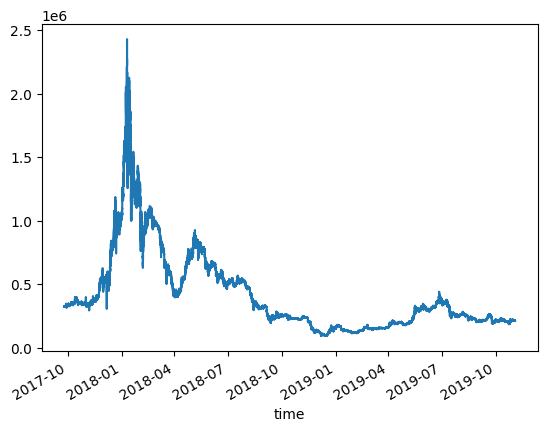

In [ ]:
# 전체 데이터는 19년도까지있다
modify_data['close'].plot()

#### 2) 데이터 라벨링하기

- 추세를 labeling하는 방식에는 여러 방식이 존재하나, 여기서는 일단 4가지 방식으로만 진행해본다.
  - 1) Price Change Direction
  - 2) Using Moving Average
  - 3) Local Min-Max
  - 4) Trend Scanning

##### 1) Price Change Direction
- 현재 가격과 특정 영업일 이전의 가격의 차이로 labeling하는 방식이다.

In [ ]:
window = 10
momentum_signal = np.sign(np.sign(modify_data['close'] - modify_data['close'].shift(window)) + 1)
s_momentum_signal = pd.Series(momentum_signal, index=modify_data.index)

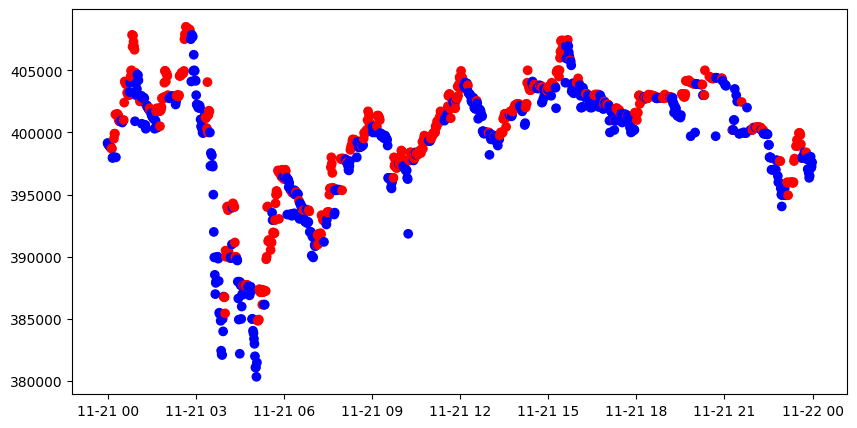

In [ ]:
sub_data = modify_data.loc['2017-11-21', 'close']
c_sig = s_momentum_signal.loc['2017-11-21']
c_sig['color'] = np.where(c_sig == 1, 'red', 'blue')

plt.figure(figsize=(10,5))
plt.scatter(sub_data.index, sub_data, c=c_sig['color'])

In [ ]:
s_momentum_signal.head(15)

,close
time,
2017-09-25 03:00:00,NaN
2017-09-25 03:01:00,NaN
2017-09-25 03:02:00,NaN
2017-09-25 03:05:00,NaN
2017-09-25 03:06:00,NaN
2017-09-25 03:07:00,NaN
2017-09-25 03:10:00,NaN
2017-09-25 03:11:00,NaN
2017-09-25 03:12:00,NaN


##### 2) Using Moving Average
- 현재의 주가가 특정 이동평균선 위에 있는지 or 아래에 있는지 여부로 labeling하는 방법이다.
  - 기술적 지표를 이용하여 labeling 하는 방식은 여러가지가 있으나, 이번 프로젝트는 이동평균선을 이용한 방식만 활용한다.

In [ ]:
momentum_signal = np.sign(np.sign(modify_data['close'] - modify_data['close'].rolling(window).mean()) + 1)
s_momentum_signal = pd.Series(momentum_signal, index=modify_data.index)

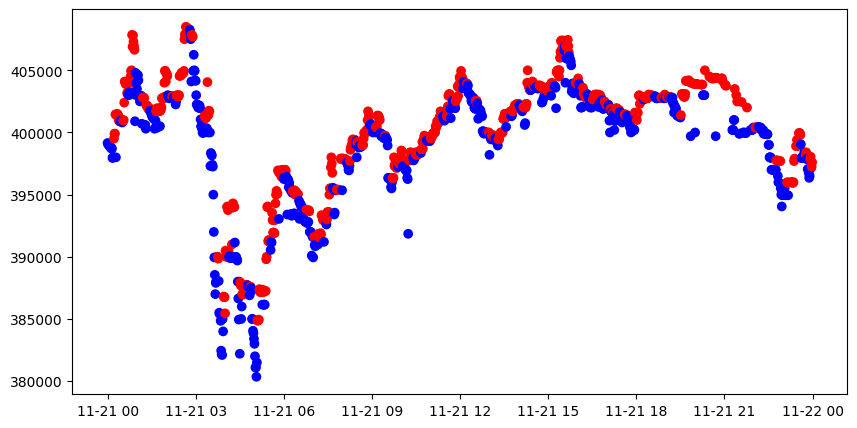

In [ ]:
sub_data = modify_data.loc['2017-11-21', 'close']
c_sig = s_momentum_signal.loc['2017-11-21']
c_sig['color'] = np.where(c_sig == 1, 'red', 'blue')

plt.figure(figsize=(10,5))
plt.scatter(sub_data.index, sub_data, c=c_sig['color'])

In [ ]:
s_momentum_signal.head(15)

,close
time,
2017-09-25 03:00:00,NaN
2017-09-25 03:01:00,NaN
2017-09-25 03:02:00,NaN
2017-09-25 03:05:00,NaN
2017-09-25 03:06:00,NaN
2017-09-25 03:07:00,NaN
2017-09-25 03:10:00,NaN
2017-09-25 03:11:00,NaN
2017-09-25 03:12:00,NaN


##### 3) Local Min-Max
- 국지적인 최소 or 최대값을 계속 갱신하여, 최소-최대 구간을 이어나가면서 labeling하는 방식이다.
- 앞선 방법들과 마찬가지로, **wait 계수**를 작게하면 변동성이 커질 수 있으므로, 계수를 신중하게 선택해야 한다!

In [ ]:
# Local min / max 를 추출하기 위한 함수
def get_local_min_max(close, wait=3):
    min_value = close.iloc[0]
    max_value = close.iloc[0]
    n_cnt_min, n_cnt_max = 0, 0

    mins, maxes = [], []
    min_idxes, max_idxes = [], []
    b_min_update, b_max_update = False, False

    for idx, val in zip(close.index[1:], close.values[1:]):
        if val < min_value:
            min_value = val
            mins.append(min_value)
            min_idxes.append(idx)
            n_cnt_min = 0
            b_min_update = True
        if val > max_value:
            max_value = val
            maxes.append(max_value)
            max_idxes.append(idx)
            n_cnt_max = 0
            b_max_update = True

        if not b_max_update:
            b_min_update = False
            n_cnt_min += 1
            if n_cnt_min >= wait:
                max_value = min_value
                n_cnt_min = 0

        if not b_min_update:
            b_max_update = False
            n_cnt_max += 1
            if n_cnt_max >= wait:
                min_value = max_value
                n_cnt_max = 0

    return pd.DataFrame.from_dict({'min_time': min_idxes, 'local_min': mins}), pd.DataFrame.from_dict({'max_time': max_idxes, 'local_max': maxes})

In [ ]:
mins, maxes = get_local_min_max(sub_data, wait=3)

(376546.5, 412585.0)

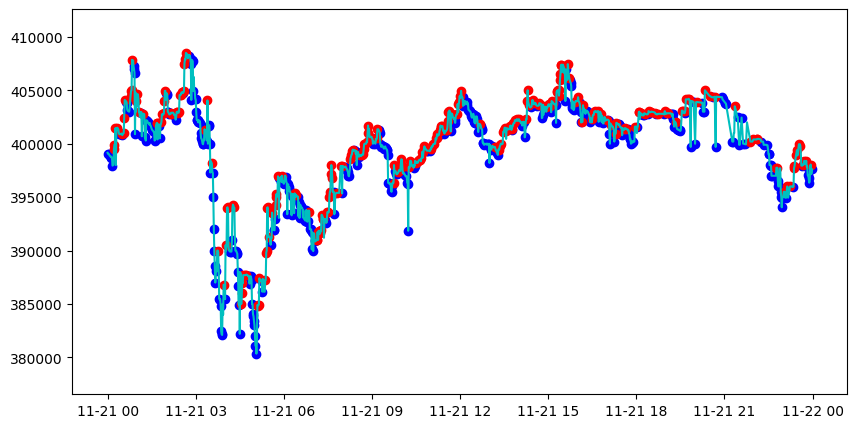

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(sub_data, 'c')
ax.scatter(mins.min_time, mins.local_min, c='blue')
ax.scatter(maxes.max_time, maxes.local_max, c='red')
ax.set_ylim([sub_data.min() * 0.99, sub_data.max()  * 1.01])

(376546.5, 412585.0)

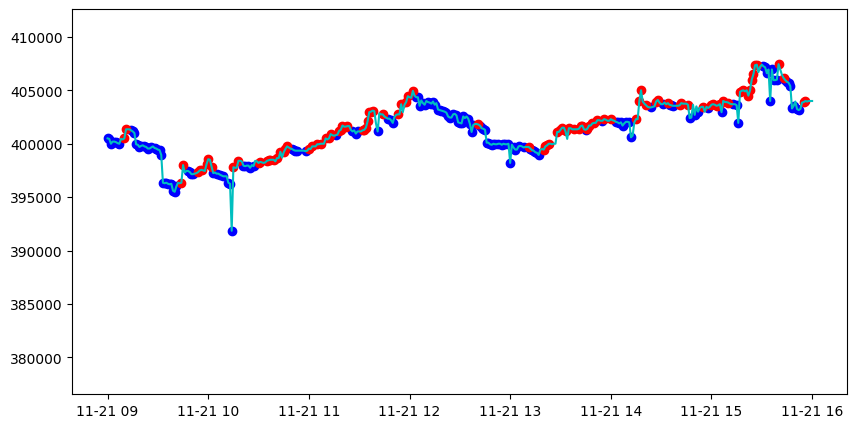

In [ ]:
st_time, ed_time = '2017-11-21 09:00:00', '2017-11-21 16:00:00'

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(sub_data.loc[st_time:ed_time], 'c')
ax.scatter(mins.set_index('min_time', drop=False).min_time.loc[st_time:ed_time], mins.set_index('min_time').local_min.loc[st_time:ed_time], c='blue')
ax.scatter(maxes.set_index('max_time', drop=False).max_time.loc[st_time:ed_time], maxes.set_index('max_time').local_max.loc[st_time:ed_time], c='red')
ax.set_ylim([sub_data.min() * 0.99, sub_data.max()  * 1.01])

In [ ]:
mins

,min_time,local_min
0,2017-11-21 00:01:00,399050
1,2017-11-21 00:03:00,399000
2,2017-11-21 00:04:00,398900
3,2017-11-21 00:05:00,398850
4,2017-11-21 00:06:00,398800
...,...,...
472,2017-11-21 23:48:00,397850
473,2017-11-21 23:50:00,397050
474,2017-11-21 23:52:00,396750
475,2017-11-21 23:53:00,396350


##### cf) 책에 없는 코드 라벨링하기

In [ ]:
## 책에 없는 코드 라벨링까지 마무리 하는 코드를 짜봅시다

# 1. 극소/극대 포인트 합치기
extrema_df = pd.concat([
    mins.rename(columns={'min_time': 'time', 'local_min': 'value'}).assign(type='min'),
    maxes.rename(columns={'max_time': 'time', 'local_max': 'value'}).assign(type='max')
])

# 2. 시간 순으로 정렬
extrema_df = extrema_df.sort_values(by='time').reset_index(drop=True)

# 3. 각 구간의 변화 방향 라벨링
trend_labels = []
for i in range(len(extrema_df) - 1):
    current_val = extrema_df.loc[i, 'value']
    next_val = extrema_df.loc[i+1, 'value']
    label = 1 if next_val > current_val else 0
    trend_labels.append(label)

# 마지막 포인트는 라벨 없음 → NaN 또는 0 처리
trend_labels.append(0)

# 4. 최종 결과
extrema_df['label'] = trend_labels
print(extrema_df.head(15))


                  time   value type  label
0  2017-11-21 00:01:00  399050  min      0
1  2017-11-21 00:03:00  399000  min      0
2  2017-11-21 00:04:00  398900  min      0
3  2017-11-21 00:05:00  398850  min      0
4  2017-11-21 00:06:00  398800  min      0
5  2017-11-21 00:07:00  398800  min      0
6  2017-11-21 00:08:00  398700  min      0
7  2017-11-21 00:10:00  397950  min      1
8  2017-11-21 00:13:00  399500  max      1
9  2017-11-21 00:14:00  399900  max      1
10 2017-11-21 00:16:00  401450  max      0
11 2017-11-21 00:19:00  401350  max      1
12 2017-11-21 00:20:00  401500  max      0
13 2017-11-21 00:23:00  401000  min      0
14 2017-11-21 00:24:00  400900  min      0


#### 3) Trend Scanning 진행하기

- ex) 시계열 데이터 xt가 주식 or 코인의 가격이라고 가정해보자.
  - 현재 t시점에서 t+l 시점까지의 회귀식을 피팅하여, 베타값을 구한다.
  - 이 베타값의 t-value를 구한다.
  - max t-value의 부호를 통해서 labeling을 진행한다.
- cf) t-value -> 두 대상이 평균적으로 얼마나 차이나는지 표현한 정도를 의미한다. t-value값이 클수록, 두 대상의 평균의 차이는 크다고 할 수 있다. t-value는 두 대상을 '평균적'으로 비교하고 싶을 때 사용한다.

In [ ]:
def t_val_lin_r(close):
    import statsmodels.api as sml

    # t-value from a linear trend
    x = np.ones((close.shape[0], 2))
    x[:, 1] = np.arange(close.shape[0])
    ols = sml.OLS(close, x).fit()
    return ols.tvalues[1]

In [ ]:
look_forward_window = 60
min_sample_length = 5
step = 1
t1_array = []
t_values_array = []

In [ ]:
# 이 코드 블럭은 실행에 20~30분정도 걸립니다.

molecule = modify_data['2017-11-01':'2017-11-30'].index
label = pd.DataFrame(index=molecule, columns=['t1', 't_val', 'bin'])
tmp_out = []

for ind in tqdm(molecule):
    subset = modify_data.loc[ind:, 'close'].iloc[:look_forward_window]  # 전방 탐색을 위한 샘플 추출
    if look_forward_window > subset.shape[0]:
        continue

    tmp_subset = pd.Series(index=subset.index[min_sample_length-1:subset.shape[0]-1])
    tval = []

    # 회귀분석을 통해 t 통계량값을 이용하여 추세 추정
    for forward_window in np.arange(min_sample_length, subset.shape[0]):
        df = subset.iloc[:forward_window]
        tval.append(t_val_lin_r(df.values))

    tmp_subset.loc[tmp_subset.index] = np.array(tval)
    idx_max = tmp_subset.replace([-np.inf, np.inf, np.nan], 0).abs().idxmax()
    tmp_t_val = tmp_subset[idx_max]
    tmp_out.append([tmp_subset.index[-1], tmp_t_val, np.sign(tmp_t_val)])

label.loc[molecule] = np.array(tmp_out)  # prevent leakage

label['t1'] = pd.to_datetime(label['t1'])
label['bin'] = pd.to_numeric(label['bin'], downcast='signed')

100%|██████████| 33384/33384 [13:54<00:00, 40.01it/s]


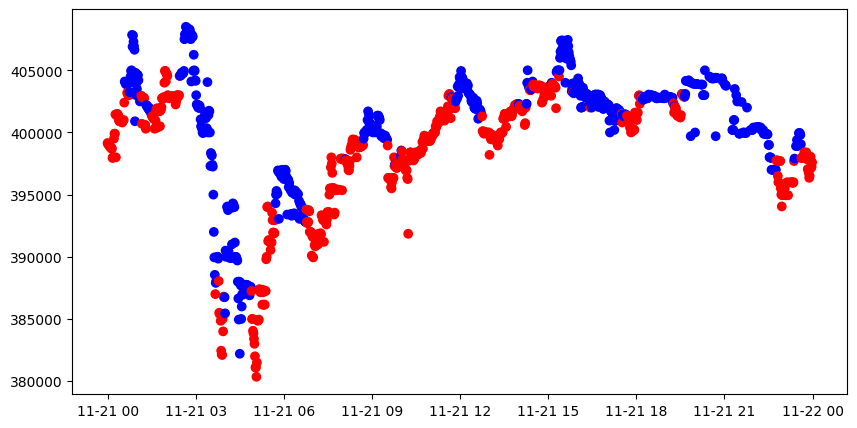

In [ ]:
sub_data = modify_data.loc['2017-11-21', 'close']
c_sig = label['bin'].loc['2017-11-21']
c_sig['color'] = np.where(c_sig == 1, 'red', 'blue')

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.scatter(sub_data.index, sub_data.values,
              c=c_sig['color'])

## 2) Feature Engineering

- 피처를 선택하는 방식에는 크게 3가지로 분류할 수 있는데, 이 중에서 **Wrapper Method** 몇 가지에 대한 사용 방법을 알아본다.

### 1) 데이터 불러오기

In [ ]:
label.head(20)

,t1,t_val,bin
time,,,
2017-11-01 00:05:00,2017-11-01 06:10:00,-6.373987,-1
2017-11-01 00:12:00,2017-11-01 06:16:00,-6.273936,-1
2017-11-01 00:18:00,2017-11-01 06:23:00,-5.897474,-1
2017-11-01 00:24:00,2017-11-01 06:29:00,-5.425023,-1
2017-11-01 00:31:00,2017-11-01 06:35:00,-5.08177,-1
2017-11-01 00:37:00,2017-11-01 06:42:00,-4.895976,-1
2017-11-01 00:43:00,2017-11-01 06:48:00,-5.11334,-1
2017-11-01 00:50:00,2017-11-01 06:54:00,-4.866885,-1
2017-11-01 00:56:00,2017-11-01 07:00:00,-3.673143,-1


In [ ]:
!pip install ta==0.9.0
!pip install shap

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.9.0-py3-none-any.whl size=28893 sha256=7845d4e4968679a05d140a869db1e1f49ab12a92aaabba49621856cf6c2eba6a
  Stored in directory: /root/.cache/pip/wheels/b5/fd/8d/250a0fe7de9a6bfc9c22235b544c550f9a868b9af79aa7e9ed
Successfully built ta


In [ ]:
import datetime
import sys
import os
import re
import io
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ta

import sys

# 이거 두개는 LMS에서는 내부 파일이 존재함
# sys.path.append('/aiffel/aiffel/fnguide/data/')
# from libs.feature_importance import importance as imp

from sklearn.feature_selection import SequentialFeatureSelector, RFECV

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier

In [ ]:
"""
mlfinlab
"""

"""
Module which implements feature importance algorithms as described in Chapter 8 of Advances in Financial Machine
Learning and Clustered Feature Importance algorithms as described in Chapter 6 Section 6.5.2 of Machine Learning for
Asset Managers.
"""

import pandas as pd
import numpy as np
from sklearn.metrics import log_loss


def mean_decrease_impurity(model, feature_names, clustered_subsets=None):
    """
    Advances in Financial Machine Learning, Snippet 8.2, page 115.
    MDI Feature importance
    Mean decrease impurity (MDI) is a fast, explanatory-importance (in-sample, IS) method specific to tree-based
    classifiers, like RF. At each node of each decision tree, the selected feature splits the subset it received in
    such a way that impurity is decreased. Therefore, we can derive for each decision tree how much of the overall
    impurity decrease can be assigned to each feature. And given that we have a forest of trees, we can average those
    values across all estimators and rank the features accordingly.
    Tip:
    Masking effects take place when some features are systematically ignored by tree-based classifiers in favor of
    others. In order to avoid them, set max_features=int(1) when using sklearn’s RF class. In this way, only one random
    feature is considered per level.
    Notes:
    * MDI cannot be generalized to other non-tree based classifiers
    * The procedure is obviously in-sample.
    * Every feature will have some importance, even if they have no predictive power whatsoever.
    * MDI has the nice property that feature importances add up to 1, and every feature importance is bounded between 0 and 1.
    * method does not address substitution effects in the presence of correlated features. MDI dilutes the importance of
      substitute features, because of their interchangeability: The importance of two identical features will be halved,
      as they are randomly chosen with equal probability.
    * Sklearn’s RandomForest class implements MDI as the default feature importance score. This choice is likely
      motivated by the ability to compute MDI on the fly, with minimum computational cost.
    Clustered Feature Importance( Machine Learning for Asset Manager snippet 6.4 page 86) :
    Clustered MDI  is the  modified version of MDI (Mean Decreased Impurity). It  is robust to substitution effect that
    takes place when two or more explanatory variables share a substantial amount of information (predictive power).CFI
    algorithm described by Dr Marcos Lopez de Prado  in Clustered Feature  Importance section of book Machine Learning
    for Asset Manager. Here  instead of  taking the importance  of  every feature, we consider the importance of every
    feature subsets, thus every feature receive the importance of subset it belongs to.
    :param model: (model object): Trained tree based classifier.
    :param feature_names: (list): Array of feature names.
    :param clustered_subsets: (list) Feature clusters for Clustered Feature Importance (CFI). Default None will not apply CFI.
                              Structure of the input must be a list of list/s i.e. a list containing the clusters/subsets of feature
                              name/s inside a list. E.g- [['I_0','I_1','R_0','R_1'],['N_1','N_2'],['R_3']]
    :return: (pd.DataFrame): Mean and standard deviation feature importance.
    """
    # Feature importance based on in-sample (IS) mean impurity reduction
    feature_imp_df = {i: tree.feature_importances_ for i, tree in enumerate(model.estimators_)}
    feature_imp_df = pd.DataFrame.from_dict(feature_imp_df, orient='index')
    feature_imp_df.columns = feature_names

    # Make sure that features with zero importance are not averaged, since the only reason for a 0 is that the feature
    # was not randomly chosen. Replace those values with np.nan
    feature_imp_df = feature_imp_df.replace(0, np.nan)  # Because max_features = 1

    if clustered_subsets is not None:
        # Getting subset wise importance
        importance = pd.DataFrame(index=feature_names, columns=['mean', 'std'])
        for subset in clustered_subsets: # Iterating over each cluster
            subset_feat_imp = feature_imp_df[subset].sum(axis=1)
            # Importance of each feature within a subsets is equal to the importance of that subset
            importance.loc[subset, 'mean'] = subset_feat_imp.mean()
            importance.loc[subset, 'std'] = subset_feat_imp.std()*subset_feat_imp.shape[0]**-.5
    else:
        importance = pd.concat({'mean': feature_imp_df.mean(),
                                'std': feature_imp_df.std() * feature_imp_df.shape[0] ** -0.5},
                               axis=1)

    importance /= importance['mean'].sum()
    return importance


def mean_decrease_accuracy(model, X, y, cv_gen, clustered_subsets=None, sample_weight_train=None,
                           sample_weight_score=None, scoring=log_loss, random_state=42):
    """
    Advances in Financial Machine Learning, Snippet 8.3, page 116-117.
    MDA Feature Importance
    Mean decrease accuracy (MDA) is a slow, predictive-importance (out-of-sample, OOS) method. First, it fits a
    classifier; second, it derives its performance OOS according to some performance score (accuracy, negative log-loss,
    etc.); third, it permutates each column of the features matrix (X), one column at a time, deriving the performance
    OOS after each column’s permutation. The importance of a feature is a function of the loss in performance caused by
    its column’s permutation. Some relevant considerations include:
    * This method can be applied to any classifier, not only tree-based classifiers.
    * MDA is not limited to accuracy as the sole performance score. For example, in the context of meta-labeling
      applications, we may prefer to score a classifier with F1 rather than accuracy. That is one reason a better
      descriptive name would have been “permutation importance.” When the scoring function does not correspond to a
      metric space, MDA results should be used as a ranking.
    * Like MDI, the procedure is also susceptible to substitution effects in the presence of correlated features.
      Given two identical features, MDA always considers one to be redundant to the other. Unfortunately, MDA will make
      both features appear to be outright irrelevant, even if they are critical.
    * Unlike MDI, it is possible that MDA concludes that all features are unimportant. That is because MDA is based on
      OOS performance.
    * The CV must be purged and embargoed.
    Clustered Feature Importance( Machine Learning for Asset Manager snippet 6.5 page 87) :
    Clustered MDA is the modified version of MDA (Mean Decreased Accuracy). It is robust to substitution effect that takes
    place when two or more explanatory variables share a substantial amount of information (predictive power).CFI algorithm
    described by Dr Marcos Lopez de Prado  in Clustered Feature  Importance (Presentation Slides)
    https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3517595. Instead of shuffling (permutating) all variables
    individually (like in MDA), we shuffle all variables in cluster together. Next, we follow all the  rest of the
    steps as in MDA. It can used by simply specifying the clustered_subsets argument.
    :param model: (sklearn.Classifier): Any sklearn classifier.
    :param X: (pd.DataFrame): Train set features.
    :param y: (pd.DataFrame, np.array): Train set labels.
    :param cv_gen: (cross_validation.PurgedKFold): Cross-validation object.
    :param clustered_subsets: (list) Feature clusters for Clustered Feature Importance (CFI). Default None will not apply CFI.
                              Structure of the input must be a list of list/s i.e. a list containing the clusters/subsets of feature
                              name/s inside a list. E.g- [['I_0','I_1','R_0','R_1'],['N_1','N_2'],['R_3']]
    :param sample_weight_train: (np.array) Sample weights used to train the model for each record in the dataset.
    :param sample_weight_score: (np.array) Sample weights used to evaluate the model quality.
    :param scoring: (function): Scoring function used to determine importance.
    :param random_state: (int) Random seed for shuffling the features.
    :return: (pd.DataFrame): Mean and standard deviation of feature importance.
    """

    if sample_weight_train is None:
        sample_weight_train = np.ones((X.shape[0],))

    if sample_weight_score is None:
        sample_weight_score = np.ones((X.shape[0],))

    fold_metrics_values, features_metrics_values = pd.Series(dtype='float64'), pd.DataFrame(columns=X.columns)
    # Generating a numpy random state object for the given random_state
    rs_obj = np.random.RandomState(seed=random_state)
    # Clustered feature subsets will be used for CFI if clustered_subsets exists else will operate on the single column as MDA
    feature_sets = clustered_subsets if clustered_subsets else [[x] for x in X.columns]
    for i, (train, test) in enumerate(cv_gen.split(X=X)):
        fit = model.fit(X=X.iloc[train, :], y=y.iloc[train], sample_weight=sample_weight_train[train])
        pred = fit.predict(X.iloc[test, :])

        # Get overall metrics value on out-of-sample fold
        if scoring == log_loss:
            prob = fit.predict_proba(X.iloc[test, :])
            fold_metrics_values.loc[i] = -scoring(y.iloc[test], prob, sample_weight=sample_weight_score[test],
                                                  labels=model.classes_)
        else:
            fold_metrics_values.loc[i] = scoring(y.iloc[test], pred, sample_weight=sample_weight_score[test])

        # Get feature specific metric on out-of-sample fold
        for j in feature_sets:
            X1_ = X.iloc[test, :].copy(deep=True)
            for j_i in j:
                rs_obj.shuffle(X1_[j_i].values)  # Permutation of a single column for MDA or through the whole subset for CFI
            if scoring == log_loss:
                prob = fit.predict_proba(X1_)
                features_metrics_values.loc[i, j] = -scoring(y.iloc[test], prob,
                                                             sample_weight=sample_weight_score[test],
                                                             labels=model.classes_)
            else:
                pred = fit.predict(X1_)
                features_metrics_values.loc[i, j] = scoring(y.iloc[test], pred,
                                                            sample_weight=sample_weight_score[test])

    importance = (-features_metrics_values).add(fold_metrics_values, axis=0)
    if scoring == log_loss:
        importance = importance / -features_metrics_values
    else:
        importance = importance / (1.0 - features_metrics_values).replace(0, np.nan)
    importance = pd.concat({'mean': importance.mean(), 'std': importance.std() * importance.shape[0] ** -.5}, axis=1)
    importance.replace([-np.inf, np.nan], 0, inplace=True)  # Replace infinite values

    return importance

- .pkl은 파이썬의 리스트, 클래스, 딕셔너리와 같은 자료형(type)을 바이너리로 변환하여 파일로 저장된 것을 말한다.
- 일반적으로 파일은 텍스트로 저장되며, 파이썬의 자료형은 객체로 저장되는데, 객체 상태로는 바로 사용할 수 없으므로, 컴퓨터가 이해할 수 있는 바이너리로 저장되어 사용할 수 있다.

In [ ]:
DATA_PATH = '.'
anno_file_name = os.path.join(DATA_PATH, '/content/sub_upbit_eth_min_tick_label.pkl')
target_file_name = os.path.join(DATA_PATH, '/content/sub_upbit_eth_min_tick.csv')

In [ ]:
df_modify_data = pd.read_csv(target_file_name, index_col=0, parse_dates=True)
df_label_data = pd.read_pickle(anno_file_name)
df_sub_modify_data = df_modify_data.loc[df_label_data.index]

# 학습 시간 단축을 위해 여기선 편의상 1000개의 데이터만 가져옵니다.
df_sub_modify_data = df_sub_modify_data.iloc[:5000]

In [ ]:
df_sub_modify_data.head()

,open,high,low,close,volume
time,,,,,
2018-01-01 00:00:00,1028000,1028000,1026500,1028000,41.835689
2018-01-01 00:01:00,1028000,1029000,1026000,1028500,22.307810
2018-01-01 00:02:00,1028000,1029000,1028000,1028000,59.276102
2018-01-01 00:03:00,1028000,1028000,1014000,1014000,114.203740
2018-01-01 00:04:00,1020000,1027000,1014500,1025000,62.695404


In [ ]:
df_label_data.head(), df_label_data.tail()

(time
 2018-01-01 00:00:00   -0.0
 2018-01-01 00:01:00   -0.0
 2018-01-01 00:02:00   -0.0
 2018-01-01 00:03:00   -1.0
 2018-01-01 00:04:00   -1.0
 Name: t_value, dtype: float64,
 time
 2019-11-03 10:29:00   NaN
 2019-11-03 10:30:00   NaN
 2019-11-03 10:31:00   NaN
 2019-11-03 10:32:00   NaN
 2019-11-03 10:33:00   NaN
 Name: t_value, dtype: float64)

In [ ]:
df_label_data.value_counts()

,count
t_value,
-1.0,306636
-0.0,302963
1.0,299289


### 2) Technical index

#### 1) 기술적 지표
- 기술적 지표 -> 시장의 주가 or 거래량 데이터를 기반으로 주가의 방향성을 예측하기 위해 고안된 지표를 말한다.
  - 여러 지표들(노드 참고)을 기존의 데이터 세트에 추가하는 과정
- 수익률/변동성 지표 -> 여러 지표들이 추가된 데이터 세트에서 활용하고자 하는 시점에 수익률과 변동성 적용한다.
- 수익률/변동성까지 적용된 데이터 세트를 표준화(standardization) -> fit_transform -> 랜덤포레스트 모델에 적용한다!

- 아래 코드는 각 지표들을 파이썬의 TA패키지를 이용하여 산출하는 코드이다.

In [ ]:
mt = 1
fillna = False
df_ = df_sub_modify_data.copy()
open, high, low, close, volume = 'open', 'high', 'low', 'close', 'volume'
cols = [open, high, low, close, volume]

## Volume Index
# Chaikin Money Flow
df_["volume_cmf"] = ta.volume.ChaikinMoneyFlowIndicator(
                        high=df_[high], low=df_[low], close=df_[close], volume=df_[volume], window=20*mt, fillna=fillna
                    ).chaikin_money_flow()
# Force Index
df_["volume_fi"] = ta.volume.ForceIndexIndicator(
                        close=df_[close], volume=df_[volume], window=15*mt, fillna=fillna
                    ).force_index()
# Money Flow Indicator
df_["volume_mfi"] = ta.volume.MFIIndicator(
                        high=df_[high],
                        low=df_[low],
                        close=df_[close],
                        volume=df_[volume],
                        window=15*mt,
                        fillna=fillna,
                    ).money_flow_index()
# Ease of Movement
df_["volume_sma_em"] = ta.volume.EaseOfMovementIndicator(
                            high=df_[high], low=df_[low], volume=df_[volume], window=15*mt, fillna=fillna
                        ).sma_ease_of_movement()

# Volume Price Trend
df_["volume_vpt"] = ta.volume.VolumePriceTrendIndicator(
                        close=df_[close], volume=df_[volume], fillna=fillna
                    ).volume_price_trend()

## volatility index
# Average True Range
df_["volatility_atr"] = ta.volatility.AverageTrueRange(
                            close=df_[close], high=df_[high], low=df_[low], window=10*mt, fillna=fillna
                        ).average_true_range()

# Ulcer Index
df_["volatility_ui"] = ta.volatility.UlcerIndex(
                            close=df_[close], window=15*mt, fillna=fillna
                        ).ulcer_index()

## trend index
# MACD
df_["trend_macd_diff"] = ta.trend.MACD(
                            close=df_[close], window_slow=25*mt, window_fast=10*mt, window_sign=9, fillna=fillna
                        ).macd_diff()

# Average Directional Movement Index (ADX)
df_["trend_adx"] = ta.trend.ADXIndicator(
                        high=df_[high], low=df_[low], close=df_[close], window=15*mt, fillna=fillna
                    ).adx()

# TRIX Indicator
df_["trend_trix"] = ta.trend.TRIXIndicator(
                        close=df_[close], window=15*mt, fillna=fillna
                    ).trix()

# Mass Index
df_["trend_mass_index"] = ta.trend.MassIndex(
                            high=df_[high], low=df_[low], window_fast=10*mt, window_slow=25*mt, fillna=fillna
                        ).mass_index()

# DPO Indicator
df_["trend_dpo"] = ta.trend.DPOIndicator(
                        close=df_[close], window=20*mt, fillna=fillna
                    ).dpo()

# Aroon Indicator
df_["trend_aroon_ind"] = ta.trend.AroonIndicator(close=df_[close], window=20, fillna=fillna).aroon_indicator()

## momentum index
# Relative Strength Index (RSI)
df_["momentum_rsi"] = ta.momentum.RSIIndicator(close=df_[close], window=15*mt, fillna=fillna).rsi()

# Williams R Indicator
df_["momentum_wr"] = ta.momentum.WilliamsRIndicator(
                        high=df_[high], low=df_[low], close=df_[close], lbp=15*mt, fillna=fillna
                    ).williams_r()

In [ ]:
# 결과 확인
df_

,open,high,low,close,volume,volume_cmf,volume_fi,volume_mfi,volume_sma_em,volume_vpt,volatility_atr,volatility_ui,trend_macd_diff,trend_adx,trend_trix,trend_mass_index,trend_dpo,trend_aroon_ind,momentum_rsi,momentum_wr
time,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00,1028000,1028000,1026500,1028000,41.835689,NaN,NaN,NaN,NaN,-5.158335,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:01:00,1028000,1029000,1026000,1028500,22.307810,NaN,NaN,NaN,NaN,-5.175414,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:02:00,1028000,1029000,1028000,1028000,59.276102,NaN,NaN,NaN,NaN,-0.017967,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:03:00,1028000,1028000,1014000,1014000,114.203740,NaN,NaN,NaN,NaN,-1.584121,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:04:00,1020000,1027000,1014500,1025000,62.695404,NaN,NaN,NaN,NaN,-0.875176,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-01-04 12:11:00,1394500,1395500,1394000,1394500,127.005807,-0.091572,23796.952475,58.252954,2.318796e+11,0.029720,4662.708350,0.398403,-531.986943,16.389054,0.050733,24.043235,5175.0,45.0,61.964269,-20.689655
2018-01-04 12:12:00,1394000,1395000,1393000,1394500,93.623047,-0.040004,20822.333416,50.844856,-2.600534e+10,0.000000,4396.437515,0.401074,-507.855388,15.796566,0.049091,23.489986,5725.0,15.0,61.964269,-20.689655
2018-01-04 12:13:00,1394000,1395500,1393000,1395500,77.296694,0.085947,27881.628448,57.859065,1.618271e+12,0.055430,4206.793764,0.383540,-432.447570,15.343572,0.047630,23.032632,-550.0,15.0,63.133792,-14.285714


#### 2) 수익률/변동성 지표
- 수익률, 변화율 지표
  - 현재가격(종가)과 직전 n-영업일 가격과의 비율 (식은 노드 참고)
  - 금일 거래량과 직전 n-영업일 거래량과의 비율 (식은 노드 참고)
- 변동성 지표
  - 종가의 n-영업일 이동 표준편차
  - 거래량의 n-영업일 이동 표준편차

In [ ]:
windows_mom = [5, 10, 20]
windows_std = [30]

for i in windows_mom:
    df_[f'vol_change_{i}'] = df_.volume.pct_change(i).round(6)
    df_[f'ret_{i}'] = df_.close.pct_change(i).round(6)

for i in windows_std:
    df_[f'std_{i}'] = df_.close.rolling(i).std()
    df_[f'vol_std_{i}'] = df_.volume.rolling(i).std()

In [ ]:
# 결과 확인
df_

,open,high,low,close,volume,volume_cmf,volume_fi,volume_mfi,volume_sma_em,volume_vpt,...,momentum_rsi,momentum_wr,vol_change_5,ret_5,vol_change_10,ret_10,vol_change_20,ret_20,std_30,vol_std_30
time,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00,1028000,1028000,1026500,1028000,41.835689,NaN,NaN,NaN,NaN,-5.158335,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:01:00,1028000,1029000,1026000,1028500,22.307810,NaN,NaN,NaN,NaN,-5.175414,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:02:00,1028000,1029000,1028000,1028000,59.276102,NaN,NaN,NaN,NaN,-0.017967,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:03:00,1028000,1028000,1014000,1014000,114.203740,NaN,NaN,NaN,NaN,-1.584121,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:04:00,1020000,1027000,1014500,1025000,62.695404,NaN,NaN,NaN,NaN,-0.875176,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-01-04 12:11:00,1394500,1395500,1394000,1394500,127.005807,-0.091572,23796.952475,58.252954,2.318796e+11,0.029720,...,61.964269,-20.689655,0.843324,0.003960,0.145439,-0.001790,-0.482002,0.005407,5160.665778,57.932297
2018-01-04 12:12:00,1394000,1395000,1393000,1394500,93.623047,-0.040004,20822.333416,50.844856,-2.600534e+10,0.000000,...,61.964269,-20.689655,-0.091642,0.001796,-0.515879,0.002516,-0.317572,0.006496,4978.805655,57.959359
2018-01-04 12:13:00,1394000,1395500,1393000,1395500,77.296694,0.085947,27881.628448,57.859065,1.618271e+12,0.055430,...,63.133792,-14.285714,-0.398666,0.001076,-0.284202,0.003235,-0.673792,0.003957,5005.428089,52.973102


In [ ]:
df_tmp_data = df_.join(df_label_data).dropna()
X, y = df_tmp_data.iloc[:, 5:-1], df_tmp_data.iloc[:, -1]

sc = StandardScaler()
X_sc = sc.fit_transform(X)
X_sc = pd.DataFrame(X_sc, index=X.index, columns=X.columns)

In [ ]:
X_sc.head()

,volume_cmf,volume_fi,volume_mfi,volume_sma_em,volume_vpt,volatility_atr,volatility_ui,trend_macd_diff,trend_adx,trend_trix,...,momentum_rsi,momentum_wr,vol_change_5,ret_5,vol_change_10,ret_10,vol_change_20,ret_20,std_30,vol_std_30
time,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:43:00,1.007239,-0.114131,0.171805,0.099083,-0.019960,-0.064444,-0.281159,0.052310,0.402173,-0.123679,...,-0.106191,0.111650,-0.122594,-0.066242,-0.119713,-0.094456,-0.118724,0.322889,-0.591998,-0.175500
2018-01-01 00:44:00,1.025096,-0.083038,0.102180,0.141432,0.038755,-0.062887,-0.306260,0.355523,0.292029,-0.108234,...,0.356523,1.136865,-0.101651,1.413390,-0.116387,-0.024055,-0.097703,0.526065,-0.561891,-0.170841
2018-01-01 00:45:00,1.014467,-0.097910,0.169775,0.165348,-0.008962,-0.128738,-0.332153,0.397472,0.172120,-0.087846,...,0.092224,0.576794,-0.071394,0.326873,-0.121124,0.046490,-0.094486,0.526996,-0.551500,-0.168233
2018-01-01 00:46:00,0.988643,-0.008030,-0.143993,0.152862,0.115456,-0.008665,-0.332153,0.804890,0.072015,-0.037644,...,0.773792,1.478603,0.032352,1.606647,-0.105312,0.468468,-0.088724,0.985331,-0.463008,-0.179759
2018-01-01 00:47:00,0.870609,-0.047136,-0.399272,0.057169,0.085259,0.099400,-0.257638,0.514564,-0.021417,-0.002975,...,-0.153770,-0.215230,-0.055795,0.228644,-0.153658,-0.023911,-0.114336,0.220474,-0.461096,-0.164205


In [ ]:
X_sc.shape

(4957, 23)

In [ ]:
rfc = RandomForestClassifier(class_weight='balanced')
rfc.fit(X_sc, y)

RandomForestClassifier(class_weight='balanced')

### 3) 피처 선택 방법
- 특성선택(Feature Selection)을 위한 기법에는 아래와 같은 방법이 있다.
  - 1) Feature Selection -> MDI, MDA
  - 2) Sequential Feature Selection -> RFE CV, SFS
  - 3) Shapley Additive explanations -> SHAP

#### 1) Feature Selection -> MDI
- MDI(Mean Decrease Impurity) -> tree 계열 분류기에서 사용되는 피처 중요도 값을 사용한 피처 선택 기법이다.
  - In-sample 방식 -> 학습 데이터의 정확도를 기반으로 하므로, In-sample이라고 한다.
  - 모든 피처가 어느 정도의 중요도를 갖는다.
  - 모든 피처 중요도의 총합 = 1
  - substitution effect를 해결하지 못한다.

In [ ]:
# LMS와 다르게 우리는 함수를 직접 호출해줘서 imp. 을 지웠습니다
# feat_imp = imp.mean_decrease_impurity(rfc, X.columns)
feat_imp = mean_decrease_impurity(rfc, X.columns)

In [ ]:
feat_imp

,mean,std
volume_cmf,0.043737,0.000791
volume_fi,0.049935,0.001460
volume_mfi,0.042397,0.000882
volume_sma_em,0.052778,0.001148
volume_vpt,0.031183,0.000635
volatility_atr,0.048365,0.000810
volatility_ui,0.047730,0.000762
trend_macd_diff,0.054347,0.001785
trend_adx,0.057607,0.000931
trend_trix,0.048913,0.000951


#### 2) Feature Selection -> MDA
- MDA(Mean Decrease Accuracy) -> tree 이외의 분류기에서도 사용 가능한 피처 선택 기법이다.
  - OOS(Out-of-sample) 방식 -> 테스트 데이터를 기준으로 정확도를 산출하는 방식이므로, OOS라고 한다.
  - 정확도(accuracy) 이외의 다른 성능 지표를 사용할 수 있다.
  - MDI와 마찬가지로, substitution effect에서 자유롭지 못하다.
  - MDI와 달리, 모든 피처가 중요하다고 나오지 않을 수도 있다.
  - 순서: 분류기 피팅 -> 성능 지표에 따라 OOS 성능 측정 -> 순차적으로 각 피처에 대해 무작위로 섞은 후, OOS 성능을 기존의 값과 비교하는 작업을 전체 피처에 대해 수행

In [ ]:
svc_rbf = SVC(kernel='rbf', probability=True)
cv = KFold(n_splits=5)
feat_imp_mda = mean_decrease_accuracy(svc_rbf, X_sc, y, cv_gen=cv)

In [ ]:
def plot_feature_importance(importance_df, save_fig=False, output_path=None):
    # Plot mean imp bars with std
    plt.figure(figsize=(10, importance_df.shape[0] / 5))
    importance_df.sort_values('mean', ascending=True, inplace=True)
    importance_df['mean'].plot(kind='barh', color='b', alpha=0.25, xerr=importance_df['std'], error_kw={'ecolor': 'r'})
    if save_fig:
        plt.savefig(output_path)
    else:
        plt.show()

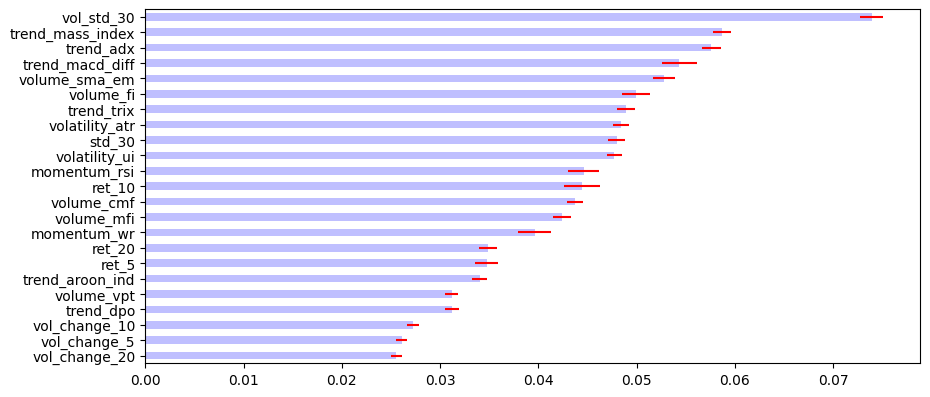

In [ ]:
# volatility_atr : 시장의 변동성(진폭)을 측정하는 지표입니다
# Average True Range (ATR)
plot_feature_importance(feat_imp)

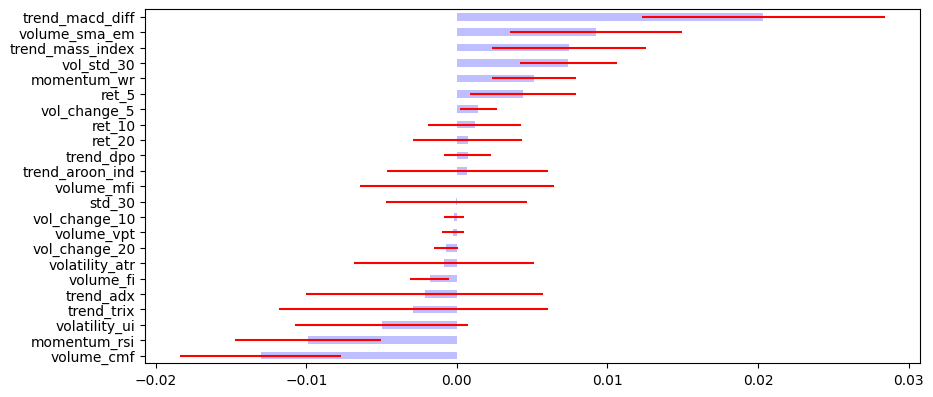

In [ ]:
plot_feature_importance(feat_imp_mda)

#### 3) Sequential Feature Selection -> RFE CV
- RFE CV(Recursive Feature Elimination) -> RFE 방식에 CV를 도입한 기법이다.
  - 데이터 세트를 k개로 분할하여, 학습/검증을 동시에 진행하며, 검증 시 피처의 기여도에 따라 삭제 여부를 결정하는 방식이다.
  - validation 성능이 가장 좋은 피처를 최종 피처로 결정한다.

In [ ]:
svc_rbf = SVC(kernel='linear', probability=True)
rfe_cv = RFECV(svc_rbf, cv=cv)
rfe_fitted = rfe_cv.fit(X_sc, y)

In [ ]:
rfe_df = pd.DataFrame([rfe_fitted.support_, rfe_fitted.ranking_], columns=X_sc.columns).T.rename(columns={0:"Optimal_Features", 1:"Ranking"})
rfe_df

,Optimal_Features,Ranking
volume_cmf,False,12
volume_fi,False,4
volume_mfi,False,14
volume_sma_em,False,7
volume_vpt,False,8
volatility_atr,True,1
volatility_ui,False,11
trend_macd_diff,True,1
trend_adx,False,19
trend_trix,False,10


In [ ]:
rfe_df[rfe_df["Optimal_Features"]==True]

,Optimal_Features,Ranking
volatility_atr,True,1
trend_macd_diff,True,1
std_30,True,1


#### 4) Sequential Feature Selection -> SFS
- SFS(Sequential Feature Selection) -> 순차적으로 피처를 더하거나 빼는 방식으로, 피처의 최적 조합을 찾는 방식이다.
  - 전진/후진 방식 모두 사용할 수 있다.
    - 전진(forward): Null에서 시작하며, 피처들을 한개씩 더해가는 방식으로 조합을 찾는다.
    - 후진(backward): 모든 피처가 있는 상태에서 시작하여 하나씩 빼가면서 조합을 찾는다.

In [ ]:
n = 2

sfs_forward = SequentialFeatureSelector(svc_rbf, n_features_to_select=n, direction='forward')
sfs_fitted = sfs_forward.fit(X_sc, y)

In [ ]:
sfs_rank = sfs_fitted.get_support()

# 최신 버전은 {} 대신 []를 사용해야함
#sfs_df = pd.DataFrame(sfs_rank, index=X_sc.columns, columns={"Optimal_Features"})
sfs_df = pd.DataFrame(sfs_rank, index=X_sc.columns, columns=["Optimal_Features"])

sfs_df [sfs_df ["Optimal_Features"]==True].index

Index(['volume_mfi', 'trend_macd_diff'], dtype='object')

#### 5) SHAP
- SHAP(Shapley Additive explanations) -> 게임이론으로부터 Shapley value를 추산하여, 이를 바탕으로 피처를 설명하는 방식이다.
  - Shapley value -> 어떤 팀이 공동으로 결과를 만들어냈을 때, 각 구성원이 결과에 얼마나 기여했는지를 공정하게 측정하는 방법.

In [ ]:
# !pip install --upgrade typing_extensions
# -> LMS에서 오류가남 버전 재설치를 해야한다
import shap
# 모델 output을 raw로 바꿔주기
explainer = shap.TreeExplainer(rfc, model_output="raw")
shap_value = explainer.shap_values(X_sc)

In [ ]:
shap_value.shape

(957, 23, 3)

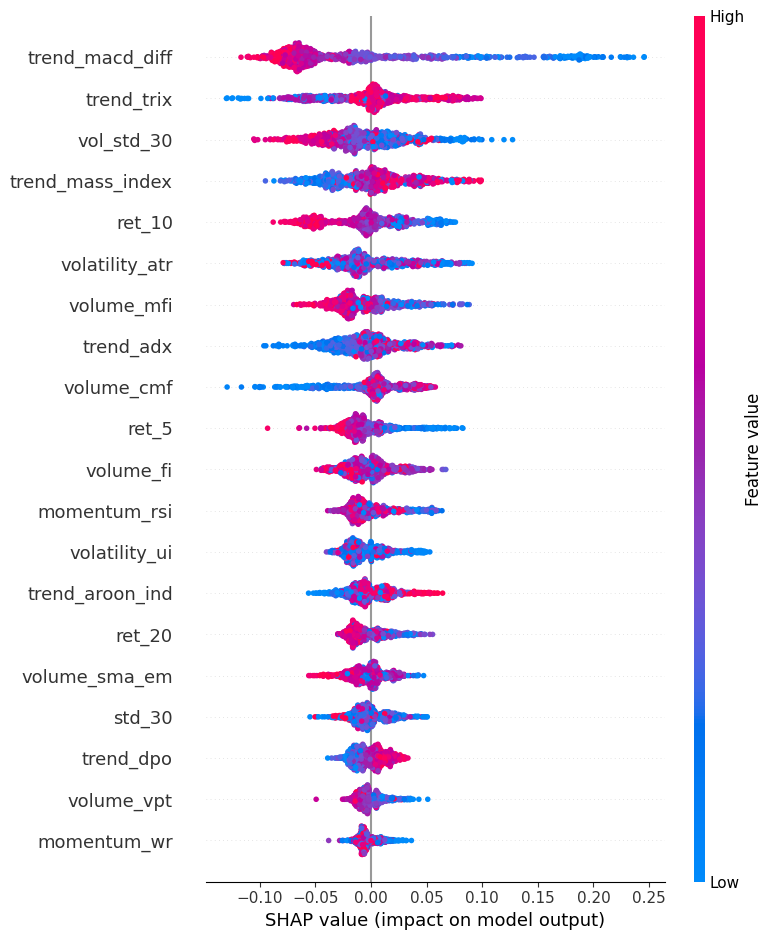

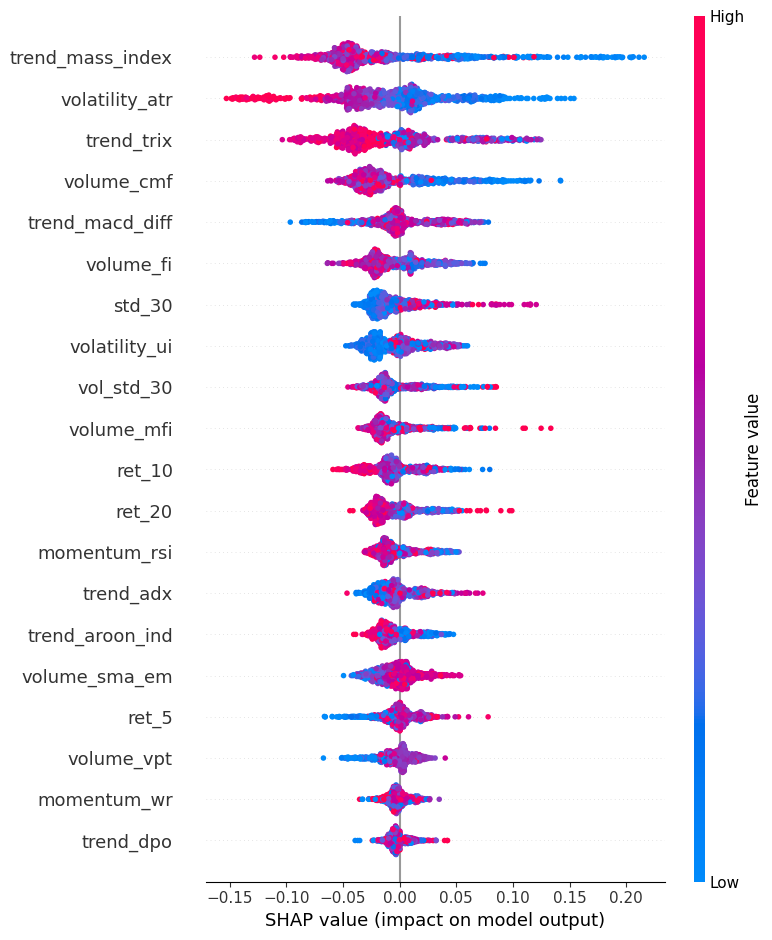

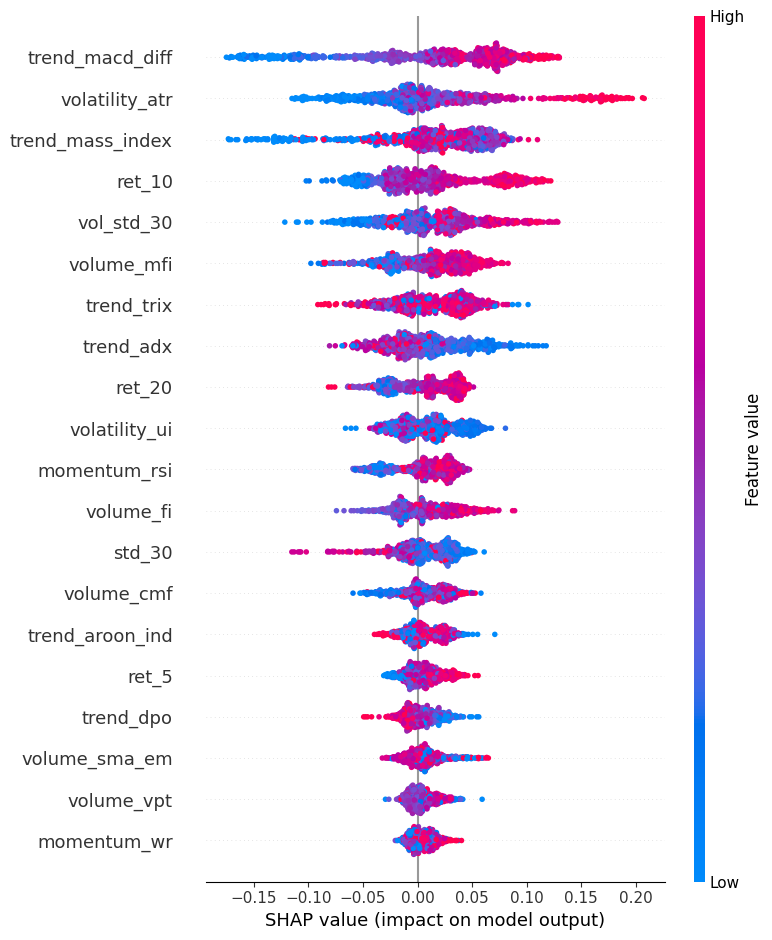

In [ ]:
# 각 클래스에 대한 각각의 plot을 그려줘야함

# 클래스 0에 대한 SHAP summary plot
shap.summary_plot(shap_value[:, :, 0], X_sc, class_names='class 0')

# 클래스 1
shap.summary_plot(shap_value[:, :, 1], X_sc, class_names='class 1')

# 클래스 2
shap.summary_plot(shap_value[:, :, 2], X_sc, class_names='class 2')

In [ ]:
# 절댓값 평균으로 전체 feature 중요도 요약
mean_shap = np.mean(np.abs(shap_value), axis=(0, 2))  # over samples and classes
shap_df = pd.Series(mean_shap, index=X_sc.columns).sort_values(ascending=False)
print(shap_df)

trend_macd_diff     0.049283
trend_mass_index    0.039888
volatility_atr      0.037169
trend_trix          0.031795
vol_std_30          0.026934
ret_10              0.026925
volume_cmf          0.022531
volume_mfi          0.022515
trend_adx           0.020996
volume_fi           0.018923
volatility_ui       0.018613
ret_20              0.018287
momentum_rsi        0.017200
std_30              0.016624
trend_aroon_ind     0.013883
ret_5               0.013307
volume_sma_em       0.012009
trend_dpo           0.009764
volume_vpt          0.009228
momentum_wr         0.007840
vol_change_10       0.004145
vol_change_20       0.003712
vol_change_5        0.002874
dtype: float64


In [ ]:
output_file_name = os.path.join(DATA_PATH, 'sub_upbit_eth_min_feature_labels.pkl')
df_tmp_data.to_pickle(output_file_name)

## 3) Model Training

### 1) 데이터 불러오기

In [ ]:
import datetime
import sys
import os
import re
import io
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ta

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, roc_auc_score, roc_curve

# sys.path.append('/aiffel/aiffel/fnguide/data/')
# from libs.mlutil.pkfold import PKFold

In [ ]:
"""
Created on Fri Dec  6 19:41:30 2019

@author: sukji
"""
from typing import Callable
import pandas as pd
import numpy as np

from sklearn.metrics import log_loss
from sklearn.model_selection import KFold
from sklearn.base import ClassifierMixin
from sklearn.model_selection import BaseCrossValidator

def ml_get_train_times1(samples_info_sets: pd.Series, test_times: pd.Series) -> pd.Series:
    # pylint: disable=invalid-name
    """
    Advances in Financial Machine Learning, Snippet 7.1, page 106.

    Purging observations in the training set

    This function find the training set indexes given the information on which each record is based
    and the range for the test set.
    Given test_times, find the times of the training observations.

    :param samples_info_sets: (pd.Series) The information range on which each record is constructed from
        *samples_info_sets.index*: Time when the information extraction started.
        *samples_info_sets.value*: Time when the information extraction ended.
    :param test_times: (pd.Series) Times for the test dataset.
    :return: (pd.Series) Training set
    """
    train = samples_info_sets.copy(deep=True)

    start = test_times.min()
    end = test_times.max()

    first = test_times.index[0]
    last = test_times.index[-1]

    df0 = train[(train < first) | (train.index > end)].index  # Train starts within test
    return df0

class PKFold(KFold):
    """
    Extend KFold class to work with labels that span intervals

    The train is purged of observations overlapping test-label intervals
    Test set is assumed contiguous (shuffle=False), w/o training samples in between

    :param n_splits: (int) The number of splits. Default to 3
    :param samples_info_sets: (pd.Series) The information range on which each record is constructed from
        *samples_info_sets.index*: Time when the information extraction started.
        *samples_info_sets.value*: Time when the information extraction ended.
    :param pct_embargo: (float) Percent that determines the embargo size.
    """

    def __init__(self,
                 n_splits: int = 3,
                 samples_info_sets: pd.Series = None,
                 pct_embargo: float = 0.):

        if not isinstance(samples_info_sets, pd.Series):
            raise ValueError('The samples_info_sets param must be a pd.Series')
        super(PKFold, self).__init__(n_splits, shuffle=False, random_state=None)

        self.samples_info_sets = samples_info_sets
        self.pct_embargo = pct_embargo

    # noinspection PyPep8Naming
    def split(self,
              X: pd.DataFrame,
              y: pd.Series = None,
              groups=None):
        """
        The main method to call for the PurgedKFold class

        :param X: (pd.DataFrame) Samples dataset that is to be split
        :param y: (pd.Series) Sample labels series
        :param groups: (array-like), with shape (n_samples,), optional
            Group labels for the samples used while splitting the dataset into
            train/test set.
        :return: (tuple) [train list of sample indices, and test list of sample indices]
        """
        if X.shape[0] != self.samples_info_sets.shape[0]:
            raise ValueError("X and the 'samples_info_sets' series param must be the same length")

        indices: np.ndarray = np.arange(X.shape[0])
        embargo: int = int(X.shape[0] * self.pct_embargo)

        test_ranges: [(int, int)] = [(ix[0], ix[-1] + 1) for ix in np.array_split(np.arange(X.shape[0]), self.n_splits)]
        for start_ix, end_ix in test_ranges:
            test_indices = indices[start_ix:end_ix]

            if end_ix < X.shape[0]:
                end_ix += embargo

            test_times = pd.Series(index=[self.samples_info_sets.index[start_ix]], data=[self.samples_info_sets[end_ix-1]])
            #train_times = ml_get_train_times(self.samples_info_sets, test_times)
            train_times = ml_get_train_times1(self.samples_info_sets, test_times)

            train_indices = []
            for train_ix in train_times:
                train_indices.append(self.samples_info_sets.index.get_loc(train_ix))
            yield np.array(train_indices), test_indices

In [ ]:
DATA_PATH = '.'
data_file_name = os.path.join(DATA_PATH, 'sub_upbit_eth_min_feature_labels.pkl')

In [ ]:
df_data = pd.read_pickle(data_file_name)
df_data['t_value'] = df_data['t_value'].apply(lambda x: x if x == 1 else 0)

In [ ]:
df_data['t_value'].value_counts()

,count
t_value,
1.0,481
0.0,476


In [ ]:
train_ratio, test_ratio = 0.7, 0.2
n_train = int(np.round(len(df_data) * train_ratio))
n_test = int(np.round(len(df_data) * test_ratio))

In [ ]:
X, y = df_data.iloc[:, 5:-1], df_data.iloc[:, -1]

sc = StandardScaler()
X_sc = sc.fit_transform(X)

In [ ]:
train_x, test_x, train_y, test_y = X_sc[:n_train, :], X_sc[-n_test:, :], y.iloc[:n_train], y.iloc[-n_test:]

train_x = pd.DataFrame(train_x, index=train_y.index, columns=X.columns)
train_y = pd.Series(train_y, index=train_y.index)
test_x = pd.DataFrame(test_x, index=test_y.index, columns=X.columns)
test_y = pd.Series(test_y, index=test_y.index)

# 학습 시간 단축을 위해 여기선 편의상 1000개의 데이터만 가져옵니다.
train_x = train_x[:1000]
train_y = train_y[:1000]

ValueError: Shape of passed values is (115, 23), indices imply (115, 24)

### 2) Purged K-fold for Cross-Validation


- 기존 K-fold CV의 문제점
  - 시계열 데이터는 시간상 자기상관이 강해서, 일반 K-fold 적용 시 정보 누수(leakage)가 발생한다.
    - ex) t 시점 데이터를 학습에, t+1 데이터를 검증에 사용하면, 두 데이터가 매우 유사해 예측 성능이 부풀려진다.
  - 학습 데이터와 검증 데이터가 시간적으로 너무 가까우면 성능이 과대평가된다.
- 따라서, 이러한 문제를 해결하기 위해 Purged K-fold CV 방식을 활용한다.
  - Purged K-fold는 학습/검증 데이터 사이에 일정한 시간 간격을 둬서 정보의 누수를 방지한다.
  - 이를 'Purging'이라고 하며, PKFold 클래스로 구현이 가능하다.
- 즉, 과적합을 방지하고, 검증의 신뢰성을 확보하고, 모델의 일반화 성능을 정확하게 평가하기 위해 Purged K-fold를 사용한다.

In [ ]:
n_cv = 4
t1 = pd.Series(train_y.index.values, index=train_y.index)
# purged K-Fold
cv = PKFold(n_cv, t1, 0)

### 3) Find the best param for bagging(랜덤포레스트) with grid-search

- ROC-AUC 곡선 -> 다양한 임계값에서 모델의 분류 성능에 대한 측정 그래프를 말한다.
- ROC-AUC의 값이 1에 가까울수록, 분류 모델의 성능이 좋다는 의미이다.

- 랜덤포레스트 모델 기반 분류기(classifier) 학습 과정
  - 1) 먼저, GridSearchCV에 들어갈 값의 파라미터를 지정하고, 랜덤포레스트 모델을 먼저 학습시킨다.
  - 2) 모델을 학습하고 나온 결과값을 **Bagging**을 통해 학습하며, 이는 오차의 분산을 줄이기 위해 사용한다.
  - 3) 앞서 GridSearchCV를 수행하기 위해 지정한 파라미터인 bc_params를 사용하고, GridSearch 클래스를 사용하여 피팅한다.
  - 4) 이렇게 찾아진 best_estimator_ 값을 기반으로 만든 분류기(classifier)를 통해 얼마나 분류가 잘됐는지 확인한다.
- Bagging (Bootstrap aggregating) -> 데이터의 복원을 허용한 랜덤 표본 추출을 뜻하며, 이렇게 추출된 표본 데이터를 바탕으로 분류기를 **병렬**로 학습시키는 것을 Bagging이라고 한다. (<-> Boosting: 잘못 예측한 데이터에 가중치를 두어 **순차적**으로 분류기를 학습하는 방식)

In [ ]:
# 최대 20분정도가 소요됩니다. 시간이 부족하다면 파라미터를 조절하여 진행하세요.
# 파라미터 명을 변경해야합니다
# 'base_estimator__max_depth': [3,5,10,20],
# base 모조리 빼버리기

bc_params = {'n_estimators': [5, 10, 20],
             'max_features': [0.5, 0.7],
             'estimator__max_depth': [3,5,10,20],
             'estimator__max_features': [None, 'auto'],
             'estimator__min_samples_leaf': [3, 5, 10],
             'bootstrap_features': [False, True]
            }

rfc = RandomForestClassifier(class_weight='balanced')
bag_rfc = BaggingClassifier(rfc)
gs_rfc = GridSearchCV(bag_rfc, bc_params, cv=cv, n_jobs=-1, verbose=1)
gs_rfc.fit(train_x, train_y)
gs_rfc_best = gs_rfc.best_estimator_

Fitting 4 folds for each of 288 candidates, totalling 1152 fits


In [ ]:
gs_rfc_best.fit(train_x, train_y)

BaggingClassifier(estimator=RandomForestClassifier(class_weight='balanced',
                                                   max_depth=5,
                                                   max_features=None,
                                                   min_samples_leaf=5),
                  max_features=0.7, n_estimators=5)

In [ ]:
pred_y = gs_rfc_best.predict(test_x)
prob_y = gs_rfc_best.predict_proba(test_x)

In [ ]:
confusion = confusion_matrix(test_y, pred_y)
accuracy  = accuracy_score(test_y, pred_y)
precision = precision_score(test_y, pred_y)
recall    = recall_score(test_y, pred_y)

print('================= confusion matrix ====================')
print(confusion)
print('=======================================================')
print(f'정확도:{accuracy}, 정밀도:{precision}, 재현율:{recall}')

================= confusion matrix ====================
[[89 47]
 [12 43]]
정확도:0.6910994764397905, 정밀도:0.4777777777777778, 재현율:0.7818181818181819


auc:0.7181149732620321


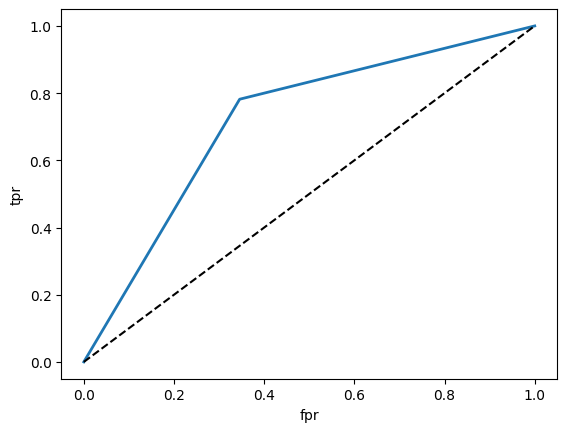

In [ ]:
fpr, tpr, thresholds = roc_curve(test_y, prob_y[:,1])
auc = roc_auc_score(test_y, prob_y[:,1])
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
plt.xlabel('fpr')
plt.ylabel('tpr')
print(f'auc:{auc}')

## [개인학습] 모델 성능 개선하기
- 1) PKFold의 split 개수 변경 -> ex) 3, 5, 7
- 2) 학습 데이터 비율 변경 -> ex) 50%, 70%
- 3) 데이터 개수 변경 -> ex) 500, 1000, 1500
- 4) 모델을 Light GBM, XGBoost도 사용


### 1) XGBoost 모델 사용해보기 (1개만 담음)
- PFKold split 수: [3,5]
- 학습 데이터의 비율: [0.5, 0.7, 1.0]
- 학습 데이터의 개수: [500, 1000, 1500]

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
import pandas as pd

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.7, 1.0],
    'colsample_bytree': [0.7, 1.0]
}

for n_cv in [3, 5]:
    for ratio in [0.5, 0.7, 1.0]:
        subset_limit = int(len(train_x) * ratio)
        for size in [500, 1000, 1500]:
            if size > subset_limit:
                continue

            # 학습 데이터 추출
            x_sub = train_x.iloc[:size]
            y_sub = train_y.iloc[:size]

            # PKFold 생성
            t1 = pd.Series(y_sub.index.values, index=y_sub.index)
            cv = PKFold(n_splits=n_cv, samples_info_sets=t1, pct_embargo=0.0)

            # GridSearchCV 정의
            xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
            grid = GridSearchCV(estimator=xgb,
                                param_grid=param_grid,
                                scoring='accuracy',
                                cv=cv,
                                n_jobs=-1,
                                verbose=0)

            # 학습
            grid.fit(x_sub, y_sub)
            best_model = grid.best_estimator_

            # 예측
            pred_y = best_model.predict(test_x)
            prob_y = best_model.predict_proba(test_x)[:, 1]

            # 평가
            accuracy = accuracy_score(test_y, pred_y)
            precision = precision_score(test_y, pred_y)
            recall = recall_score(test_y, pred_y)
            auc = roc_auc_score(test_y, pred_y)

            print('================= [XGBoost + GridSearchCV] Confusion Matrix ====================')
            print(confusion_matrix(test_y, pred_y))
            print('=================================================================================')
            print(f'정확도: {accuracy}, 정밀도: {precision}, 재현율: {recall}, AUC: {auc}')
            print(f'CV Split 수: {n_cv}, 학습 비율: {ratio}, 데이터 수: {size}')
            print("최적의 하이퍼파라미터:", grid.best_params_)
            print()

================= [XGBoost + GridSearchCV] Confusion Matrix ====================
[[49 87]
 [ 3 52]]
정확도: 0.5287958115183246, 정밀도: 0.37410071942446044, 재현율: 0.9454545454545454, AUC: 0.6528743315508021
CV Split 수: 3, 학습 비율: 1.0, 데이터 수: 500
최적의 하이퍼파라미터: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}

================= [XGBoost + GridSearchCV] Confusion Matrix ====================
[[45 91]
 [ 5 50]]
정확도: 0.4973821989528796, 정밀도: 0.3546099290780142, 재현율: 0.9090909090909091, AUC: 0.6199866310160429
CV Split 수: 5, 학습 비율: 1.0, 데이터 수: 500
최적의 하이퍼파라미터: {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}



### 2) 데이터 10000개로 늘리기

Fitting 3 folds for each of 32 candidates, totalling 96 fits
================= [XGBoost + GridSearchCV] Confusion Matrix ====================
[[76 60]
 [13 42]]
정확도: 0.6178010471204188, 정밀도: 0.4117647058823529, 재현율: 0.7636363636363637, AUC: 0.6612299465240642
최적의 하이퍼파라미터: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.7}


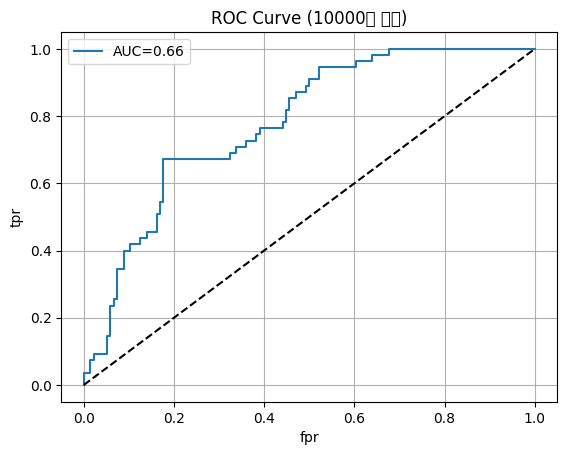

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix, roc_curve
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

# 1. 학습 데이터 확장 (10000개)
subset_size = 10000
x_sub = train_x.iloc[:subset_size]
y_sub = train_y.iloc[:subset_size]

# 2. PKFold 설정
t1 = pd.Series(y_sub.index.values, index=y_sub.index)
cv = PKFold(n_splits=3, samples_info_sets=t1, pct_embargo=0.0)

# 3. 하이퍼파라미터 그리드 설정
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.7, 1.0],
    'colsample_bytree': [0.7, 1.0]
}

# 4. GridSearchCV 설정 및 학습
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
grid = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring='accuracy', cv=cv, n_jobs=-1, verbose=1)
grid.fit(x_sub, y_sub)

# 5. 예측 및 평가
best_model = grid.best_estimator_
pred_y = best_model.predict(test_x)
prob_y = best_model.predict_proba(test_x)[:, 1]

accuracy = accuracy_score(test_y, pred_y)
precision = precision_score(test_y, pred_y)
recall = recall_score(test_y, pred_y)
auc = roc_auc_score(test_y, pred_y)

# 6. 결과 출력
print('================= [XGBoost + GridSearchCV] Confusion Matrix ====================')
print(confusion_matrix(test_y, pred_y))
print('=================================================================================')
print(f'정확도: {accuracy}, 정밀도: {precision}, 재현율: {recall}, AUC: {auc}')
print("최적의 하이퍼파라미터:", grid.best_params_)

# 7. ROC Curve
fpr, tpr, thresholds = roc_curve(test_y, prob_y)
plt.plot(fpr, tpr, label=f'AUC={auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC Curve (10000개 학습)')
plt.grid(True)
plt.legend()
plt.show()


### 3) 라벨링 방법 개선
- 위의 코드에서 계속 사용된 label은, 단순히 가격이 오르면 1, 떨어지면 0인 라벨이다. -> 이것을 매우 작은 가격 변화는 제외하고, 확실하게 상승 or 하락한 경우만 예측하도록 바꿔봤다.
- 0.2% 이상 상승하면 '상승', -0.2% 이하 하락하면 '하락' -> -0.2% <= 변화 <= +0.2%는 잘 모르므로 그냥 제외했다.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# 1. 파일 경로 (Colab 환경)
data_file_path = '/content/sub_upbit_eth_min_feature_labels.pkl'

# 2. 파일 불러오기
df_data = pd.read_pickle(data_file_path)

# 3. 수익률 계산 및 라벨 재정의 (±0.2% 이내는 NaN)
df_data['return'] = df_data['close'].pct_change().shift(-1)

def relabel(r):
    if r > 0.002:
        return 1
    elif r < -0.002:
        return 0
    else:
        return np.nan

df_data['filtered_label'] = df_data['return'].apply(relabel)

# 4. NaN 라벨 제거
df_filtered = df_data.dropna(subset=['filtered_label'])

# 5. Feature/Label 구성
X = df_filtered.iloc[:, 5:-2]  # 기존 피처 선택
y = df_filtered['filtered_label']

# 6. 정규화
sc = StandardScaler()
X_scaled = sc.fit_transform(X)

# 7. 시간 순서 기반 train/test split
train_ratio, test_ratio = 0.7, 0.2
n_train = int(np.round(len(X_scaled) * train_ratio))
n_test = int(np.round(len(X_scaled) * test_ratio))

train_x = pd.DataFrame(X_scaled[:n_train], index=y.iloc[:n_train].index, columns=X.columns)
test_x = pd.DataFrame(X_scaled[-n_test:], index=y.iloc[-n_test:].index, columns=X.columns)
train_y = y.iloc[:n_train]
test_y = y.iloc[-n_test:]

# 8. 라벨 분포 확인
print("새로운 라벨 분포:\n", y.value_counts())

새로운 라벨 분포:
 filtered_label
1.0    90
0.0    74
Name: count, dtype: int64


- 위에서 다시 만든 새로운 라벨을 가지고, 모델을 학습한다.
- XGBoost + PKFold + GridSearchCV 진행

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix

from sklearn.model_selection import KFold


# 교차검증 세팅
from typing import Callable
class PKFold(KFold):  # 이전에 정의한 PKFold 그대로 사용
    def __init__(self, n_splits, samples_info_sets, pct_embargo=0.0):
        super().__init__(n_splits=n_splits, shuffle=False)
        self.samples_info_sets = samples_info_sets
        self.pct_embargo = pct_embargo
    def split(self, X, y=None, groups=None):
        indices = np.arange(X.shape[0])
        embargo = int(X.shape[0] * self.pct_embargo)
        test_ranges = [(ix[0], ix[-1] + 1) for ix in np.array_split(indices, self.n_splits)]
        for start_ix, end_ix in test_ranges:
            test_indices = indices[start_ix:end_ix]
            train_indices = np.setdiff1d(indices, test_indices)
            yield train_indices, test_indices


# GridSearchCV 설정
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.7, 1.0]
}

subset_size = len(train_x)
x_sub = train_x
y_sub = train_y
t1 = pd.Series(y_sub.index.values, index=y_sub.index)
cv = PKFold(n_splits=3, samples_info_sets=t1)

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
grid = GridSearchCV(xgb, param_grid, cv=cv, scoring='accuracy', verbose=1, n_jobs=-1)
grid.fit(x_sub, y_sub)


# 평가
best_model = grid.best_estimator_
pred_y = best_model.predict(test_x)
prob_y = best_model.predict_proba(test_x)[:, 1]

print('Confusion Matrix:\n', confusion_matrix(test_y, pred_y))
print(f'정확도: {accuracy_score(test_y, pred_y):.4f}')
print(f'정밀도: {precision_score(test_y, pred_y):.4f}')
print(f'재현율: {recall_score(test_y, pred_y):.4f}')
print(f'AUC: {roc_auc_score(test_y, pred_y):.4f}')
print('최적 하이퍼파라미터:', grid.best_params_)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
Confusion Matrix:
 [[ 9  8]
 [ 5 11]]
정확도: 0.6061
정밀도: 0.5789
재현율: 0.6875
AUC: 0.6085
최적 하이퍼파라미터: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.7}


### 4) 라벨링 개선 + 랜덤포레스트 모델
- 더이상 성능이 좋아지지 않고, 오히려 더 떨어져서.. 나중에 데이터톤 종료 시 개인적으로 해볼 예정이다..! ㅠㅠ